In [3]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

In [4]:
results_path = Path("../../../results/classifiers")
STEP = "model_selection"

In [5]:
models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
    "nomic-ai/modernbert-embed-base",
    "Alibaba-NLP/gte-modernbert-base",
    "ibm-granite/granite-embedding-english-r2",
    "google/embeddinggemma-300m",
    "Qwen/Qwen3-Embedding-0.6B",
]
models_names = [mn.replace('/', '--') for mn in models]

strategies = [
    "mention_text",
    "concat_prefix",
    "concat_suffix",
    "span_embedding",
]

In [4]:
from transformers import AutoConfig
model_types = {m: AutoConfig.from_pretrained(m).model_type for m in models}
model_types_df = pd.DataFrame.from_dict(model_types, orient='index', columns=['model_type']).reset_index(level=0, names=['model_name'])
model_types_df

,model_name,model_type
0,sentence-transformers/all-MiniLM-L6-v2,bert
1,sentence-transformers/all-mpnet-base-v2,mpnet
2,nomic-ai/modernbert-embed-base,modernbert
3,Alibaba-NLP/gte-modernbert-base,modernbert
4,ibm-granite/granite-embedding-english-r2,modernbert
5,google/embeddinggemma-300m,gemma3_text
6,Qwen/Qwen3-Embedding-0.6B,qwen3


In [5]:
from sentence_transformers import SentenceTransformer

model_sizes = {
    m: sum(p.numel() for p in SentenceTransformer(m, device='cpu').parameters())
    for m in models
}
model_sizes_df = pd.DataFrame.from_dict(model_sizes, orient='index', columns=['num_parameters']).reset_index(level=0, names=['model_name'])
model_sizes_df['model_size'] = model_sizes_df['num_parameters'].apply(lambda x: f"{x/1e6:.1f}M")
model_sizes_df.sort_values('num_parameters', inplace=True)
model_sizes_df

,model_name,num_parameters,model_size
0,sentence-transformers/all-MiniLM-L6-v2,22713216,22.7M
1,sentence-transformers/all-mpnet-base-v2,109486464,109.5M
2,nomic-ai/modernbert-embed-base,149014272,149.0M
3,Alibaba-NLP/gte-modernbert-base,149014272,149.0M
4,ibm-granite/granite-embedding-english-r2,149014272,149.0M
5,google/embeddinggemma-300m,307581696,307.6M
6,Qwen/Qwen3-Embedding-0.6B,595776512,595.8M


- the five smallest models are based on encoder-only architectures:
    - with 22.7M parameters, the smallest model (`sentence-transformers/all-MiniLM-L6-v2`) is a little less then one fifth the size of the next larger model (`sentence-transformers/all-mpnet-base-v2` with 109.5M parameters)
    - the next bigger models are all based on `modernbert-base` and therefore have 149M parameters (`nomic-ai/modernbert-embed-base`, `Alibaba-NLP/gte-modernbert-base`, `ibm-granite/granite-embedding-english-r2`)
- the two larger models are both based on (decoder-only) LLMs and therefore two respectively four times as large as the bigger encoder-only embedding models:
    - `google/embeddinggemma-300m` with 307.6M parameters
    - and `Qwen/Qwen3-Embedding-0.6B` with 595.8M parameters

In [6]:
# get color palette for strategies
strategy_palette = sns.color_palette("husl", len(strategies))
# create a custom legend below the plots with correct colors
strategy_legend_labels = strategies
strategy_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(strategy_legend_labels)
]

## attribute dimension classification

In [7]:
task = "attribute_dimension_classification"
label_classes = ["economic", "noneconomic"]

### Model selection step

In [8]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})

df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['model'] = df['model_name'].str.split('--', expand=True)[1]
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

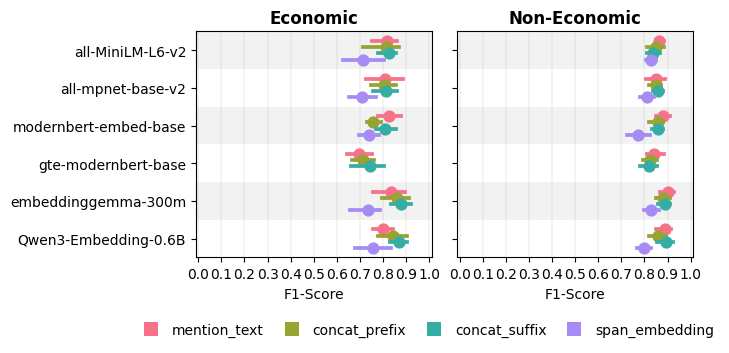

In [11]:
pdat = df.query("what in @label_classes").copy()
pdat['dim'] = pdat['what'].str.replace('non', 'non-')

fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True, constrained_layout=True)

for ax, (dim, subdf) in zip(axes, pdat.groupby("dim")):
    # ax.xaxis.set_minor_locator(AutoMinorLocator(1))

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    # add major and minor grid lines
    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",
        hue="strategy",
        palette=strategy_palette,
        errorbar=('ci', 95),
        # reduce the size of poinst
        # sizes=3,
        # capsize=.05,
        # err_kwgs={'width': .75},
        # # do not connect the points
        # 
        linestyle='none',
        dodge=0.5,
        # place legend outside
        legend=False
    )

    # add bold title and labels
    ax.set_title(dim.title(), fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
fig.legend(
    handles=strategy_legend_elements, 
    ncol=len(strategy_legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.15),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

In [12]:
model_sizes['Qwen/Qwen3-Embedding-0.6B']/model_sizes['sentence-transformers/all-MiniLM-L6-v2']

NameError: name 'model_sizes' is not defined

Insights

- overall, using only the mention text as classifier input works best for attribute dimension classification
    - the only exception is the relatively large Qwen3-Embddding-0.6B model
- with this strategy, `embeddinggemma-300m` consistenly achieves top performance
- yet, while larger models tend to perform overall slightly better it is remarkable 
    - that the head win is often rather small 
    - and even the smallest model achieves competitive results despite having about 26 times _fewer_ parameters than the largerst one
- from this analysis, `embeddinggemma-300m` emerges as the most reliable base model for classifier fine-tuning.

In [13]:
pdat.query("strategy=='mention_text'").groupby(['model_name'],observed=False)['f1-score'].mean().sort_values(ascending=False)

model_name
google--embeddinggemma-300m                  0.868503
nomic-ai--modernbert-embed-base              0.854328
Qwen--Qwen3-Embedding-0.6B                   0.844354
sentence-transformers--all-MiniLM-L6-v2      0.841265
sentence-transformers--all-mpnet-base-v2     0.828380
Alibaba-NLP--gte-modernbert-base             0.769082
ibm-granite--granite-embedding-english-r2         NaN
Name: f1-score, dtype: float64

In [14]:
# regress F1 score on strategy, conditional on model and controlling for dim
# !pip install statsmodels==0.14.5
import statsmodels.api as sm
from statsmodels.formula.api import ols

# model = ols("f1 ~ C(strategy)*C(model) + C(dim)", data=pdat.rename(columns={"f1-score": "f1"})).fit()
model = ols("f1 ~ C(strategy) + C(model) + C(dim)", data=pdat.rename(columns={"f1-score": "f1"})).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     f1   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     17.00
Date:                Thu, 05 Feb 2026   Prob (F-statistic):           3.58e-21
Time:                        08:41:02   Log-Likelihood:                 324.13
No. Observations:                 230   AIC:                            -628.3
Df Residuals:                     220   BIC:                            -593.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.8282      0.012     66.756      0.000       0.804       0.853
C(strategy)[T.concat_prefix]         -0.0084      0.011     -0.761      0.447      -0.030       0.013
C(strategy)[T.concat_suffix]          0.0064      0.011      0.577      0.564      -0.015       0.028
C(strategy)[T.span_embedding]        -0.0777      0.012     -6.611      0.000      -0.101      -0.055
C(model)[T.all-MiniLM-L6-v2]         -0.0201      0.014     -1.487      0.139      -0.047       0.007
C(model)[T.all-mpnet-base-v2]        -0.0262      0.014     -1.941      0.054      -0.053       0.000
C(model)[T.embeddinggemma-300m]       0.0123      0.014      0.909      0.365      -0.014       0.039
C(model)[T.gte-modernbert-base]      -0.0842      0.015     -5.683      0.000      -0.113      -0.055
C(model)[T.modernbert-embed-base]    -0.0262      0.014     -1.935      0.054      -0.053       0.000
C(dim)[T.non-economic]                0.0603      0.008      7.566      0.000       0.045       0.076
==============================================================================
Omnibus:                        9.542   Durbin-Watson:                   2.511
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.559
Skew:                          -0.484   Prob(JB):                      0.00840
Kurtosis:                       3.245   Cond. No.                         8.16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Granular attributes classification

### Economic attributes

In [16]:
task = "economic_attributes_classification"
label_classes = [
    # 'economic__class_membership',
    'economic__education_level',
    'economic__occupation_profession',
    'economic__employment_status',
    'economic__income_wealth_economic_status',
    # 'economic__ecology_of_group',
]

#### Model selection step

In [17]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [18]:
df['model'] = df['model_name'].str.split('--', expand=True)[1]

In [19]:
df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

In [20]:
df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

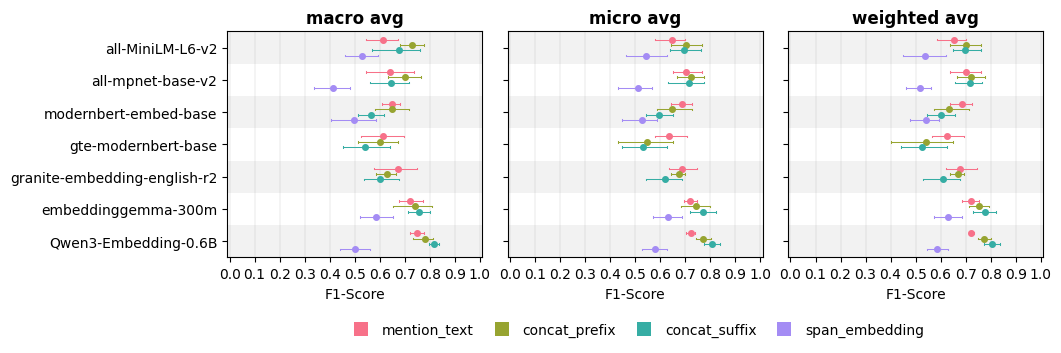

In [21]:
metrics = ["weighted avg", "macro avg", "micro avg"]
pdat = df.query("what in @metrics").copy()

fig, axes = plt.subplots(1, 3, figsize=(7*1.5, 3), sharey=True, constrained_layout=True)

# get color palette for strategies
palette = sns.color_palette("husl", len(strategies))

for ax, (metric, subdf) in zip(axes, pdat.groupby("what")):

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    # add major and minor grid lines
    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",

        hue="strategy",
        palette=strategy_palette,
        dodge=0.5,

        linestyle='none',
        markersize=3,

        errorbar='ci',
        capsize=.05,
        err_kws={'linewidth': .75},

        legend=False
    )

    # add bold title and labels
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
legend_labels = df['strategy'].unique()
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(legend_labels)
]
fig.legend(
    handles=legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.15),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

In [22]:
# NOTE: the small models are very competitive when focusing on mention-text only strategy

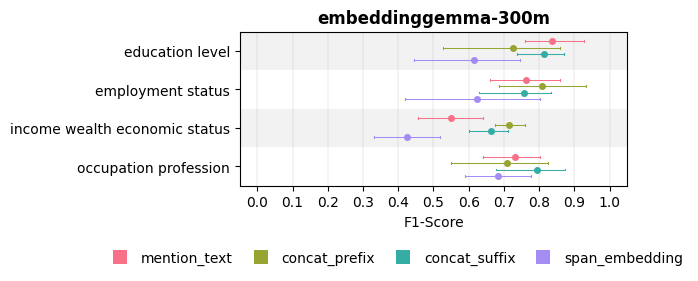

In [28]:
model = "embeddinggemma-300m"
pdat = df.query("model==@model and what in @label_classes").copy()

pdat["attribute"] = pdat["what"].str.replace("economic__", "").str.replace("_", " ")

# clip f1-scores to [0, 1]
pdat.loc[:, "f1-score"] = pdat["f1-score"].clip(0, 1)

plt.figure(figsize=(5, pdat["attribute"].nunique()/2))

# add grey horizontal stripes at alternating y positions
for i in range(pdat['attribute'].nunique()):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

# add major and minor grid lines
ls = '-' # (0, (5, 10))

plt.grid(axis='x', which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    
    markersize=3,
    linestyle='none',
    
    hue="strategy",
    palette=strategy_palette,
    dodge=0.5,
    
    errorbar='ci',
    capsize=.05,
    err_kws={'linewidth': .75},
    
    legend=False
)

# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

plt.legend(
    handles=strategy_legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.4, -0.6),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # # align center
    # 
)
plt.show()

In [29]:
# NOTE: here, mention text only strategy is most stable

In [30]:
pdat_agg = pdat.query("strategy=='concat_prefix'").groupby(["attribute"]).agg(
    f1=("f1-score", "mean"),
    f1_std=("f1-score", "std"),
    support=("support", "mean"),
    support_std=("support", "std"),
).reset_index()

Text(0, 0.5, '$N_{test}$')

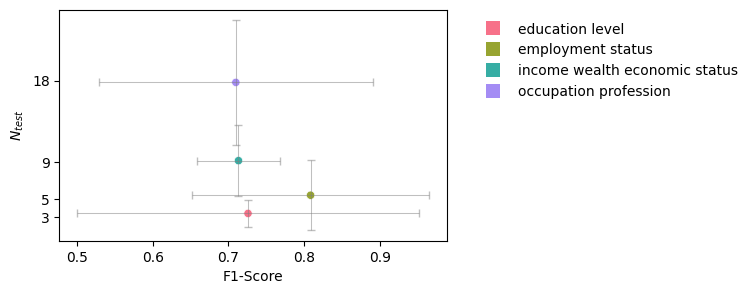

In [31]:
# using `pdat`, create a scatter plot of `f1-score`` against `support`

attributes = pdat_agg['attribute'].unique()
attributes_palette = sns.color_palette("husl", len(attributes))

plt.figure(figsize=(5, 3))


# add vertical error bars for stddev of f1-score
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        xerr=row["f1_std"],
        fmt='none',
        ecolor='gray',
        # palette=attributes_palette,
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )
# add horizontal error bars for stddev of support
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        yerr=row["support_std"],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )


sns.scatterplot(
    data=pdat_agg,
    y="support",
    x="f1",
    hue="attribute",
    palette=attributes_palette,
    alpha=1,
    # s=100,
    legend=False
)

plt.yticks(pdat_agg.support.round(0))

# create custom legend handles for attributes
attributes = pdat_agg['attribute'].unique()
attributes_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=attributes_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(attributes)
]
# show legend 
plt.legend(
    handles=attributes_legend_elements,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
)
plt.xlabel("F1-Score")
plt.ylabel("$N_{test}$")

#### Error analysis

- get predicted labels for val sets of different folds
- compute misclassification rates across models and strategies
- review mis-classified instances

In [32]:
# results_dir = results_path / task / STEP / "setfit"

preds_df = pd.concat({
    fp.parts[-5:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['model'] = preds_df['model_name'].str.split('--', expand=True)[1]
preds_df['model_name'] = pd.Categorical(preds_df['model_name'], categories=models_names, ordered=True)
preds_df['strategy'] = pd.Categorical(preds_df['strategy'], categories=strategies, ordered=True)

preds_df = preds_df.sort_values(["method", "model_name", "strategy", "mention_id", "attribute", "fold"]).reset_index(drop=True)

In [33]:
preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [34]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [35]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [36]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for (a, l), subdf in error_rates_df.groupby(['attribute', 'label']):
    # print attribute name in bold
    print(f"\033[1m{a}\033[0m ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
    for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
        highlighted_text = highlight(row['text'], row['mention'])
        print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
    print()

economic__education_level ~> false positives

economic__education_level ~> false negatives
  -  14110_201904-203887-1 (1.00):  People who are not well, especially boys, are getting worse.
  -  43110_201910-107604-1 (0.77):  Those who missed the start of a training should get a second chance.
  -  43810_201910-108153-2 (0.69):  These include well-educated individuals, restraining regulation, a competitive tax environment, political stability, and the protection of intellectual property.
  -  53110_199706-276868-1 (0.50):  6. A reduction of the maximum size of the larger second-level schools to between 350 and 500 pupils.
  -  86710_201804-274934-1 (0.44):  The same is needed for young people who are unable or unwilling to integrate into the normal educational system because of their behavioral problems.
  -   42420_199910-10164-1 (0.35):  Rather, it is about promoting people either of origin in a structured education system according to their talents as best possible.

economic__employm

<Axes: >

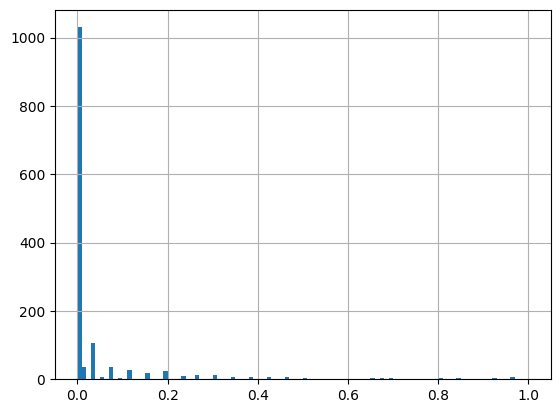

In [37]:
error_rates_df.error.hist(bins=100)

In [38]:
error_rates_df_review_economic = error_rates_df.copy()

error_rate_threshold_economic = np.quantile(error_rates_df.error, 0.95)
print(error_rate_threshold_economic)
error_rates_df_review_economic['label'] = error_rates_df_review_economic['label'].astype(str)
idxs = error_rates_df_review_economic.error > error_rate_threshold_economic
error_rates_df_review_economic.loc[idxs, 'label'] = error_rates_df_review_economic.loc[idxs, 'label'].astype(str) + '??'

0.38461538461538464


In [39]:
# error_rates_df_review_economic = error_rates_df_review_economic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
# error_rates_df_review_economic.columns.name = None

# these = error_rates_df_review_economic.iloc[:, 4:].apply(lambda row: row.apply(lambda v: '??' in v).any(), axis=1)
# error_rates_df_review_economic = error_rates_df_review_economic[these]

# len(error_rates_df_review_economic)

### Non-economic attributes

In [40]:
task = "noneconomic_attributes_classification"
label_classes = [
    'noneconomic__age',
    'noneconomic__crime',
    'noneconomic__ethnicity',
    'noneconomic__family',
    'noneconomic__gender_sexuality',
    'noneconomic__health',
    'noneconomic__nationality',
    'noneconomic__place_location',
    'noneconomic__religion',
    'noneconomic__shared_values_mentalities',
]

#### Model selection step

In [41]:
results_dir = results_path / task / STEP / "setfit"

df = pd.concat({
    fp.parts[-5:-1]: pd.read_json(fp).T.reset_index(level=0, names="what") 
    for fp in results_dir.glob("**/eval_results.json")
})
df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)

In [42]:
df['model'] = df['model_name'].str.split('--', expand=True)[1]

In [43]:
df['model_name'] = pd.Categorical(df['model_name'], categories=models_names, ordered=True)
df['strategy'] = pd.Categorical(df['strategy'], categories=strategies, ordered=True)

In [156]:
df.sort_values(["method", "model_name", "strategy", "fold"], inplace=True)

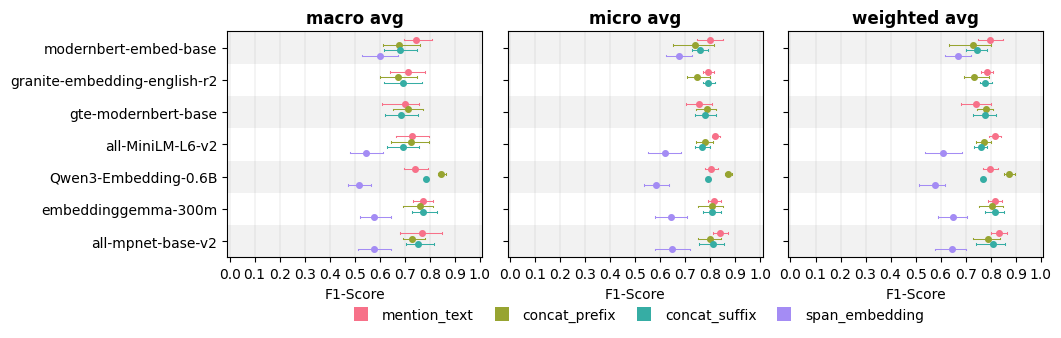

In [44]:
metrics = ["weighted avg", "macro avg", "micro avg"]
pdat = df.query("what in @metrics").copy()

fig, axes = plt.subplots(1, 3, figsize=(7*1.5, 3), sharey=True, constrained_layout=True)

# get color palette for strategies
palette = sns.color_palette("husl", len(strategies))

for ax, (metric, subdf) in zip(axes, pdat.groupby("what")):

    # add grey horizontal stripes at alternating y positions
    for i in range(len(models_names)):
        if i % 2 == 0:
            ax.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

    ls = '-' # (0, (5, 10))
    ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

    sns.pointplot(
        ax=ax,
        data=subdf,
        y="model",
        x="f1-score",
        hue="strategy",
        palette=strategy_palette,
        errorbar='ci',
        # reduce the size of poinst
        markersize=3,
        capsize=.05,
        err_kws={'linewidth': .75},
        # do not connect the points
        linestyle='none',
        dodge=0.5,
        # place legend outside
        legend=False
    )

    # add bold title and labels
    ax.set_title(metric, fontweight='bold')
    ax.set_xlabel("F1-Score")
    ax.set_ylabel("")
    ax.set_xlim(-0.01, 1.01)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# create a custom legend below the plots with correct colors
legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=strategy_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(strategies)
]
fig.legend(
    handles=legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.6, -0.1),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # align center
    bbox_transform=fig.transFigure,
)
fig.show()

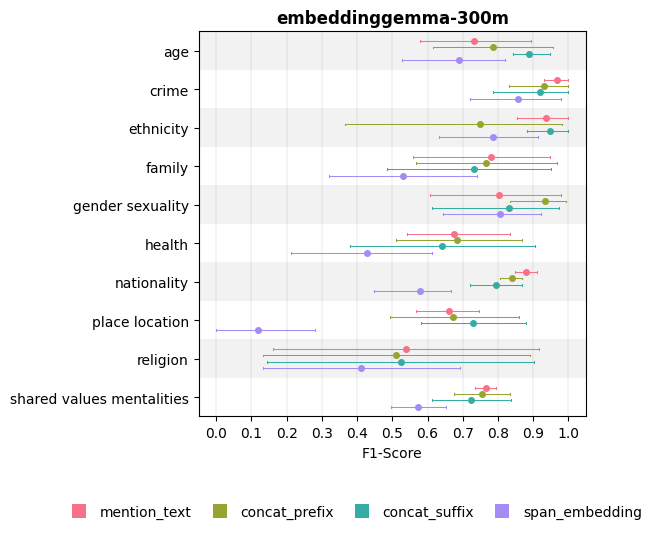

In [46]:
model = "embeddinggemma-300m"
pdat = df.query("model==@model and what in @label_classes").copy()

pdat["attribute"] = pdat["what"].str.replace("noneconomic__", "").str.replace("_", " ")

# clip f1-scores to [0, 1]
pdat.loc[:, "f1-score"] = pdat["f1-score"].clip(0, 1)

plt.figure(figsize=(5, pdat["attribute"].nunique()/2))

# add grey horizontal stripes at alternating y positions
for i in range(pdat['attribute'].nunique()):
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, color='gray', alpha=0.1, zorder=0, linewidth=0)

# add major and minor grid lines
ls = '-' # (0, (5, 10))
plt.grid(axis='x', which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)

sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    hue="strategy",
    palette=strategy_palette,
    errorbar='ci',
    # reduce the size of poinst
    markersize=3,
    capsize=.05,
    err_kws={'linewidth': .75},
    # do not connect the points
    linestyle='none',
    dodge=0.5,
    # place legend outside
    legend=False
)

# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

plt.legend(
    handles=strategy_legend_elements, 
    ncol=len(legend_labels), 
    loc='lower center', bbox_to_anchor=(0.4, -0.3),
    frameon=False,
    # reduce space between legend items
    handletextpad=0.5,
    columnspacing=1,
    # # align center
    # 
)
plt.show()


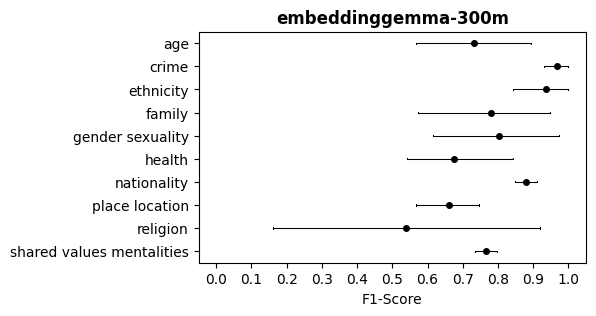

In [47]:
pdat = pdat.query("strategy=='mention_text'").copy()

plt.figure(figsize=(5, 3))

# add major and minor grid lines
ls = '-' # (0, (5, 10))
ax.xaxis.grid(which='major', linestyle=ls,  linewidth=0.25, color='gray', alpha=0.5)
# # add minor ticks (2 for each major tick)
# ax.xaxis.grid(which='minor', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
# ax.xaxis.minorticks_on()
sns.pointplot(
    data=pdat,
    y="attribute",
    x="f1-score",
    
    color='black',
    markersize=3,
    linestyle='none',
    
    errorbar='ci',
    capsize=.05,
    err_kws={'linewidth': .75},
    # legend=False
)
# add bold title and labels
plt.title(model, fontweight='bold')
plt.xlabel("F1-Score")
plt.ylabel("")
plt.xlim(-0.05, 1.05)
plt.xticks(np.arange(0, 1.1, 0.1))

# plt.legend(
#     handles=strategy_legend_elements, 
#     ncol=len(legend_labels), 
#     loc='lower center', bbox_to_anchor=(0.4, -0.35),
#     frameon=False,
#     # reduce space between legend items
#     handletextpad=0.5,
#     columnspacing=1,
#     # # align center
#     # 
# )
plt.show()

In [48]:
pdat_agg = pdat.query("strategy=='mention_text'").groupby(["attribute"]).agg(
    f1=("f1-score", "mean"),
    f1_std=("f1-score", "std"),
    support=("support", "mean"),
    support_std=("support", "std"),
).reset_index()

Text(0, 0.5, '$N_{eval}$')

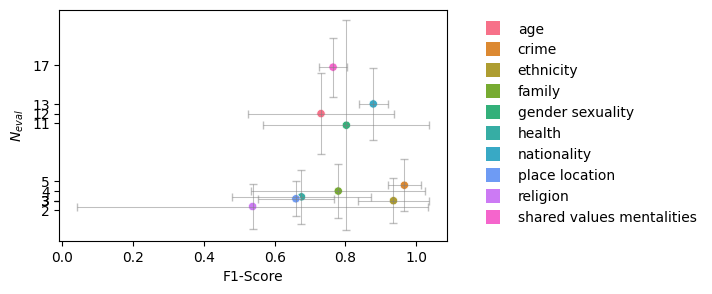

In [49]:
# using `pdat`, create a scatter plot of `f1-score`` against `support`

attributes = pdat_agg['attribute'].unique()
attributes_palette = sns.color_palette("husl", len(attributes))

plt.figure(figsize=(5, 3))


# add vertical error bars for stddev of f1-score
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        xerr=row["f1_std"],
        fmt='none',
        ecolor='gray',
        # palette=attributes_palette,
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )
# add horizontal error bars for stddev of support
for i, row in pdat_agg.iterrows():
    plt.errorbar(
        x=row["f1"],
        y=row["support"],
        yerr=row["support_std"],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=3,
        elinewidth=0.75
    )


sns.scatterplot(
    data=pdat_agg,
    y="support",
    x="f1",
    hue="attribute",
    palette=attributes_palette,
    alpha=1,
    # s=100,
    legend=False
)

plt.yticks(pdat_agg.support.round(0))

# create custom legend handles for attributes
attributes = pdat_agg['attribute'].unique()
attributes_legend_elements = [
    Line2D([0], [0], marker='s', color='w', label=label, markerfacecolor=attributes_palette[i], markersize=10, markeredgewidth=0) 
    for i, label in enumerate(attributes)
]
# show legend 
plt.legend(
    handles=attributes_legend_elements,
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=False,
)
plt.xlabel("F1-Score")
plt.ylabel("$N_{eval}$")

#### Error analysis

In [50]:
preds_df = pd.concat({
    fp.parts[-5:-1]: pd.read_pickle(fp)
    for fp in results_dir.glob("**/eval_predictions.pkl")
})
preds_df.reset_index(level=[0,1,2,3], names=["method", "model_name", "strategy", "fold"], inplace=True)
# get index of column "span"
i = preds_df.columns.get_loc("span")
key_cols = preds_df.columns[:i+1]
preds_df_long = preds_df.melt(id_vars=key_cols, var_name="attribute", value_name="value")

preds_df_long['what'] = preds_df_long['attribute'].str.extract('^(prob|pred|error)_.+$')
preds_df_long.loc[preds_df_long['what'].isnull(), 'what'] = 'label'
preds_df_long['attribute'] = preds_df_long['attribute'].str.replace('^(prob|pred|error)_', '', regex=True)

preds_df = preds_df_long.pivot(index=[*key_cols, 'attribute'], columns='what', values='value').reset_index()
preds_df.columns.name = None

preds_df['model'] = preds_df['model_name'].str.split('--', expand=True)[1]
preds_df['model_name'] = pd.Categorical(preds_df['model_name'], categories=models_names, ordered=True)
preds_df['strategy'] = pd.Categorical(preds_df['strategy'], categories=strategies, ordered=True)

preds_df = preds_df.sort_values(["method", "model_name", "strategy", "mention_id", "attribute", "fold"]).reset_index(drop=True)

In [51]:
preds_df['label'] = preds_df['label'].astype(int)
preds_df['pred'] = preds_df['pred'].astype(int)
preds_df['prob'] = preds_df['prob'].astype(float)
preds_df['error'] = preds_df['error'].astype(bool)

In [52]:
# compute error rate
id_cols = ['mention_id', 'text', 'mention', 'span', 'attribute', 'label']
error_rates_df = preds_df.groupby(id_cols, observed=False).agg({'error': 'mean'}).reset_index()

In [53]:
error_rates_df.sort_values('error', ascending=False, inplace=True)

In [55]:
highlight = lambda text, mention: text.replace(mention, '\u001B[30m\u001B[43m'+mention+'\033[0m')

threshold = 1/3
label_id_2_error_type = {0: 'false positives', 1: 'false negatives'}
for (a, l), subdf in error_rates_df.groupby(['attribute', 'label']):
    # print attribute name in bold
    print(f"\033[1m{a}\033[0m ~> \033[1m\033[3m{label_id_2_error_type[l]}\033[0m")
    for i, row in subdf[subdf['error'] > threshold].head(20).iterrows():
        highlighted_text = highlight(row['text'], row['mention'])
        print(f"  - {row['mention_id'].rjust(22)} ({row['error']:.2f}):  {highlighted_text}")
    print()

noneconomic__age ~> false positives
  - 171101_200306-303319-1 (0.83):  In 40% of the families of these young people, the characteristics of the reference group of their children are unknown, as well as the activities they regularly carry out.
  -  51110_201912-247923-1 (0.64):  This includes low to medium income families with children, young people and students, and some pensioners.
  -  86710_201004-267081-1 (0.58):  The number of high school graduates is constantly decreasing because higher education institutions rarely require high school graduates.

noneconomic__age ~> false negatives
  -  51620_198706-225844-1 (1.00):  Fourth, elderly, disabled, mentally ill and mentally handicapped people, should be cared for within the community whenever this is right for them.
  -  51320_198306-223343-2 (0.96):  For those who require long-term care - elderly, mentally handicapped, mentally ill and disabled people - develop services within both the health service and the local authority service

<Axes: >

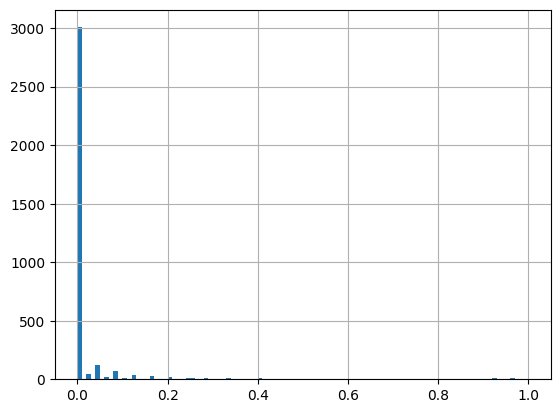

In [56]:
error_rates_df.error.hist(bins=100)

In [57]:
error_rates_df_review_noneconomic = error_rates_df.copy()

error_rate_threshold_economic = np.quantile(error_rates_df.error, 0.95)
print(error_rate_threshold_economic)

error_rates_df_review_noneconomic['label'] = error_rates_df_review_noneconomic['label'].astype(str)
idxs = error_rates_df_review_noneconomic.error > error_rate_threshold_economic
error_rates_df_review_noneconomic.loc[idxs, 'label'] = error_rates_df_review_noneconomic.loc[idxs, 'label'].astype(str) + '??'

0.20642006802720972


### Export high-error rate mentions for human review

In [58]:
error_rates_df_review_economic = error_rates_df_review_economic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
error_rates_df_review_economic.columns.name = None

error_rates_df_review_noneconomic = error_rates_df_review_noneconomic.pivot(index=['mention_id', 'text', 'mention', 'span'], columns='attribute', values='label').reset_index()
error_rates_df_review_noneconomic.columns.name = None

In [61]:
error_rates_df_review = error_rates_df_review_economic.merge(error_rates_df_review_noneconomic)
these = error_rates_df_review.iloc[:, 4:].apply(lambda row: row.apply(lambda v: '??' in v).any(), axis=1)
error_rates_df_review = error_rates_df_review[these]

len(error_rates_df_review)

184

In [ ]:
# NOTE: this export was done before dicsarding econ: class membership econ: ecology_of_group categories, so not replicable directly
# base_path = Path("../../")
# annotations_path = base_path / "data" / "annotations" / "group_mention_categorization"
# dest = annotations_path / "attribute-misclassification-review"
# dest.mkdir(parents=True, exist_ok=True)
# fp = dest / "sample.csv"
# error_rates_df_review.to_excel(fp, index=False)